In [142]:
using DifferentialEquations

function Lorenz!(dy,y,params,t)
    s,r,b=params
    dy[1] = s* ( y[2] - y[1] )
    dy[2] = r * y[1] - y[2] - y[1] * y[3]
    dy[3] = y[1] * y[2] - b * y[3]
end


function stabilized_Lorenz!(dy,y,params,t)
    s,r,b,K,y_upo,dt=params
    #println(t)
    
    #println(t)
    #println(mod(Int(floor(t/dt)),length(y_upo))+1)
    
    dy[1] = s* ( y[2] - y[1] )
    dy[2] = r * y[1] - y[2] - y[1] * y[3] + K*(y_upo[mod(Int(floor(t/dt)),length(y_upo))+1]-y[2])
    dy[3] = y[1] * y[2] - b * y[3]
end


function saturated_stabilized_Lorenz!(dy,y,params,t)
    s,r,b,K,y_upo,dt,f0=params
    f = K*(y_upo[mod(Int(floor(t/dt)),length(y_upo))+1]-y[2])
    f = f > f0 ? f0 : f
    dy[1] = s* ( y[2] - y[1] )
    dy[2] = r * y[1] - y[2] - y[1] * y[3] + f
    dy[3] = y[1] * y[2] - b * y[3]
end

saturated_stabilized_Lorenz! (generic function with 1 method)

In [2]:
using PyCall


py"""
import numpy as np
def loadUPOS(fileName):
    time_upo = []
    r_upo = []
    with open(fileName) as my_file:
        for ind_l,line in enumerate(my_file):
            if(ind_l>=24 and line!='\n'):
                #print(line==False)
                t_i,x_i,y_i,z_i = [float(i) for i in line.split()]
                time_upo.append(t_i)
                r_upo.append([x_i,y_i,z_i])
    time_upo = np.array(time_upo)
    r_upo = np.array(r_upo)
    return time_upo,r_upo
"""

fileName = "Lorenz_Database/Lorenz_CompleteOrbits/LLR_orbit.txt"
time_upo,r_upo = py"loadUPOS"(fileName)



([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3], [-3.7826474467063593 -0.2805998267141289 27.0; -3.4514294901792795 -0.3262305203652623 26.300263902404318; … ; -4.38938968142374 -0.25797329781998546 28.152530210281345; -3.9962952904278395 -0.26411784854608955 27.42240350533758])

Test that everything works fine

In [13]:
s,r,b = 10.0,28.0,8.0/3.0
K = 20.0
y_upo = r_upo[:,2]
dt =0.01
params = [s,r,b,K,y_upo,dt]
u0 = [0.01,0.0,27.0]
tspan = [0.0,2000.0]
all_t = tspan[1]:0.01:tspan[2]
prob = ODEProblem(stabilized_Lorenz!,u0,tspan,params;dtmax=dt,dt=dt,adaptive=false,alg=Euler())
sol = solve(prob);

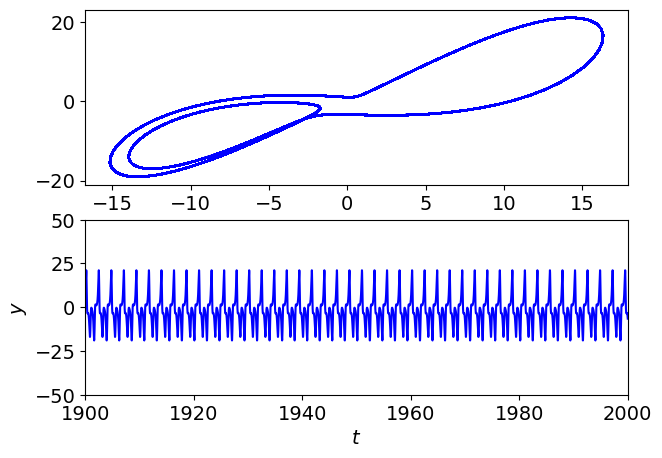

In [16]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 14;

fig,ax = plt.subplots(2,sharex=false,figsize=(7,5))

ax[1].plot(sol[1,Int(floor(length(sol.t)//2)):end],sol[2,Int(floor(length(sol.t)//2)):end],c="b")

ax[2].plot(sol.t,sol[2,:],c="b")
#ax[2].set_xlim([sol.t[1],30])
ax[2].set_xlim([1900,2000])
ax[2].set_ylim([-50,50])
ax[2].set_xlabel(L"$t$")
ax[2].set_ylabel(L"$y$")
plt.show()

In [133]:
y_upo_ext=zeros(length(sol[2,:]))
L = length(y_upo)
dt = 0.01
for (ind,t) in enumerate(sol.t)
    y_upo_ext[ind] = y_upo[mod(Int(floor(t/dt)),length(y_upo))+1]
end

In [166]:
using Random
rng = MersenneTwister(42)
u0 = rand(rng,(3))*20 .-10

3-element Array{Float64,1}:
 0.5331830160438613
 0.4540291355871424
 0.017686826714964354

In [237]:
using Statistics
@time begin
    s,r,b = 10.0,28.0,8.0/3.0
    K = 20.0
    y_upo = r_upo[:,2]
    dt =0.01

    u0 = [0.01,0.0,27.0]
    tspan = [0.0,200.0]

    all_K = 0:0.5:20

    all_D2_1 = []
    all_D4_1= []
    rand_L = 200
    for K in all_K
        temp_D2=0.0
        temp_D4=0.0
        for _ in 1:rand_L
            u0 = rand(rng,(3))*20 .-10
            params = [s,r,b,K,y_upo,dt]
            prob = ODEProblem(stabilized_Lorenz!,u0,tspan,params;dtmax=dt,dt=dt,adaptive=false,alg=Euler())
            sol = solve(prob);
            temp_D2+=mean((sol[2,:].-y_upo_ext).^2)
            temp_D4+=mean((sol[2,:].-y_upo_ext).^4)
        end
            
        push!(all_D2_1,temp_D2/rand_L)
        push!(all_D4_1,temp_D4/rand_L)
    end
    
    f0 = 10
    all_D2_2 = []
    all_D4_2= []
    for K in all_K
        temp_D2=0.0
        temp_D4=0.0
        for _ in 1:rand_L
            u0 = rand(rng,(3))*20 .-10
            params = [s,r,b,K,y_upo,dt,f0]
            prob = ODEProblem(saturated_stabilized_Lorenz!,u0,tspan,params;dtmax=dt,dt=dt,adaptive=false,alg=Euler())
            sol = solve(prob);
            temp_D2+=mean((sol[2,:].-y_upo_ext).^2)
            temp_D4+=mean((sol[2,:].-y_upo_ext).^4)
        end
            
        push!(all_D2_2,temp_D2/rand_L)
        push!(all_D4_2,temp_D4/rand_L)
    end
    
    f0 = 5
    all_D2_3 = []
    all_D4_3= []
    for K in all_K
        temp_D2=0.0
        temp_D4=0.0
        for _ in 1:rand_L
            u0 = rand(rng,(3))*20 .-10
            params = [s,r,b,K,y_upo,dt,f0]
            prob = ODEProblem(saturated_stabilized_Lorenz!,u0,tspan,params;dtmax=dt,dt=dt,adaptive=false,alg=Euler())
            sol = solve(prob);
            temp_D2+=mean((sol[2,:].-y_upo_ext).^2)
            temp_D4+=mean((sol[2,:].-y_upo_ext).^4)
        end
            
        push!(all_D2_3,temp_D2/rand_L)
        push!(all_D4_3,temp_D4/rand_L)
    end
end    

5724.947736 seconds (66.36 G allocations: 1.425 TiB, 9.04% gc time)


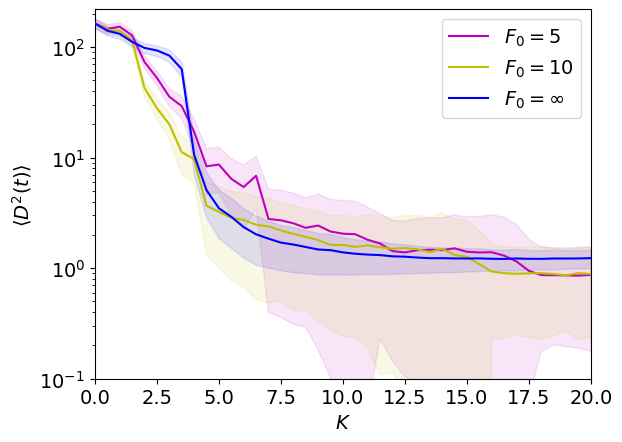

In [239]:
fig,ax = plt.subplots(1)

all_D2_1error = sqrt.((all_D4_1.-all_D2_1.^2)./rand_L)
all_D2_2error = sqrt.((all_D4_2.-all_D2_2.^2)./rand_L)
all_D2_3error = sqrt.((all_D4_3.-all_D2_3.^2)./rand_L)

ax.plot(all_K,all_D2_3,label=L"$F_0 = 5$",c="m",zorder=5)
ax.plot(all_K,all_D2_2,label=L"$F_0 = 10$",c="y",zorder=5)
ax.plot(all_K,all_D2_1,label=L"$F_0 = \infty$",c="b",zorder=5)

ax.fill_between(all_K,all_D2_3+all_D2_3error, all_D2_3-all_D2_3error,alpha=0.1,color="m")
ax.fill_between(all_K,all_D2_2+all_D2_2error, all_D2_2-all_D2_2error,alpha=0.1,color="y")
ax.fill_between(all_K,all_D2_1+all_D2_1error, all_D2_1-all_D2_1error,alpha=0.1,color="b")

ax.set_yscale("log")

ax.set_ylabel(L"$\langle D^2(t)\rangle$")
ax.set_xlabel(L"$K$")
ax.legend()
ax.set_xlim([all_K[1],all_K[end]])
ax.set_ylim([0.1,220])
#ax.set_ylim([0.5,200])
plt.savefig("Divergence.png",box_inches="tight")